# Sweep U Values
This program changes the interaction energy between the particles U. 

Typically it returns a plot of the energy bands of the system as a function of U with the PR represented in the colorscale. 

However, a variation of the program can also be used to plot the evolution of the states as U changes, what enables us to make an animation of evolution of some wavefunctions with U. (We will call the functions used for U with the label {EvStatU})

In [305]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import sin
from numpy import pi
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [306]:
#Here we consider m=1, ħ=1 and a lattice with distance L=1 between each site, so the lattice constant is 2
N=20 #Number of sites on the chain
J1=0.1 #Intra-cell hopping
J2=1 #Inter-cell hopping
#If J2>J1 we're in the topological phase
JM=max(J1, J2)
Jm=min(J1, J2)
ω=2 #On-site potential
weight=0.01 #Random perturbation to the onsite potential ω0 -> ω in [ω0-weight, ω0+weight]

In these functions we define annihilation and creation operators:
$$a |n\rangle = \sqrt{n} |n-1\rangle \qquad a^\dagger |n \rangle = \sqrt{n+1} |n+1  \rangle$$

In [307]:
#Annihilation operator
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))
#Creation operator
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [308]:
#Function that computes the bra-ket of two states
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [309]:
#Here we obtain the random perturbation to the onsite potential, it is important that the 
#perturbed ω array is the same for all values of U.
n_eigval=int(N*(N+1)/2)
if ω==0:
    ω_array=2*weight*(np.random.rand(N)-0.5)
else:
    ω_array=ω*(1+2*weight*(np.random.rand(N)-0.5))
ω_matrix=np.zeros((n_eigval, n_eigval))
counter=0
for l in range(N):
    for k in range(l,N):
        ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])
        counter+=1

In [310]:
#Function that computes a matrix element of the Hamiltonian between states <bra| and |ket> <bra|H|ket>
@numba.jit(float64(float64[:],float64[:],float64, int64, int64, int64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, i2, j2):
    n_eigval=N*(N+1)/2
    H=0

    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))

    bracket1 = bracket(bra, ket)
    #On-site interaction term of the Hamiltonian ω*Σ_i (n_i <bra|ket>)
    #H += np.sum(ω_matrix[i2, j2]*ket*bracket1) 
    H+=(ω_matrix[i2, j2]*bracket1) 
    #Inter-particle interaction term of the Hamiltonian U/2*Σ_i (n_i(n_i-1) <bra|ket>)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    #Compute the boundaries of the system: Typically we set Hard Boundary Conditions, but Periodic Boundary
    #Conditions can be chosen too.
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    if (N-1)%2==0:
        J=-J1
    else:
        J=-J2
    #P.B.C.
    #ket_aux[0], coef_term2=a(ket_aux[0])
    #H.B.C.
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    
    for i in range(len(ket)-1):
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            #coef_term2=coef_term2_aux=coef_term3=coef_term3_aux=0
            if i%2==0:
                J=-J1
            else:
                J=-J2
            #Term J a^+_i a_(i+1)
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            #Term J a^+_(i+1) a_i
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)

            #print(term2, term3)
            H+=term2+term3
    #print("\n")
    return H

In [311]:
#This function computes all of the matrix elements of the Hamiltonian given the basis of the system
@numba.jit(float64[:,:](float64,float64[:,:], int64), nopython = True, parallel = False)
def ComputeH(U,base, N):
    n_eigval=int(N*(N+1)/2)
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, i2, j2)
    return H

In [312]:
#This function computes the 1-particle Hamiltonian very fast as its matrix expression is easy
#It doesn't work with the 2 particle Hamiltonian
@numba.jit(float64[:, :](int64, float64, float64, float64), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2, Δ):
    aux_N=int(N/2) #Number of unit cells
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    H=J1*aux1+J2*aux2+ω*np.eye(N)
    return H

#{EvStatU}
#This function makes a 2D plot of the eigenvectors
#The reason why the numba line is commented is that it did not work right 
#@numba.jit(nopython=False, parallel=False)
def PlotEigvect2D(i_Eig, eigvect, U_aux):
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['font.size']=24
    EigV_i=(abs(eigvect[:, i_Eig]))**2
    maxV=0.25
    minV=0
    eigvect2D=np.zeros((N, N))
    #eigvect2Daux=np.zeros((N,N))
    counter=0
    for i in range(N):
        for j in range(i, N):
            eigvect2D[i, j]=EigV_i[counter]
            eigvect2D[j, i]=EigV_i[counter]
            counter+=1
    fig=plt.figure(figsize=[7,7])
    #plt.subplot2grid((3,6), auxpos)
    plt.gca().set_aspect('equal')
    plt.pcolor(eigvect2D)
    cb= plt.colorbar(shrink=0.75, ticks=[0.05,0.10, 0.15, 0.20, 0.25])
    cb.set_label(label=r'$|\psi(x,y)|^2$')
    plt.xlabel("x")
    plt.ylabel("y")
    """a=25
    x=np.linspace(0, a, 100)
    xa=np.linspace(0,20,100)
    xaa=np.linspace(0, a/2, 100)
    plt.plot(x, -x+a)
    plt.plot(xa, xa)
    plt.plot(a/2*np.ones(100),xaa)"""
    #fig.tick_params(label_size=15)
    #plt.title("Mapping of the 2-particle wavefunction to a 2D plot \n Each of the axis represents the position on the lattice of one particle")
    plt.tight_layout()
    plt.savefig("2DPlotEigvect_"+str(i_Eig)+"_m_"+str(U_aux)+".png")
    plt.show()

In [313]:
#This function only works if we work with SSH model with U=0
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:]))(int64), nopython = True, parallel = False)
def ComputeIndexes(N):    
    H1p=FastHamiltonian(N, J1, J2, 0)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvalNeg=eigval1p[:int(N/2)]
    if J2>J1:
        InterestingIndex=np.argmax(eigvalNeg)
    else:
        InterestingIndex=-100
    E_teorIndep=[]
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexBulkBulk, IndexBulkEdge, IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep)
#ComputeIndexes(10)

In [314]:
#This function computes the eigenvalues, eigenvectors and PR for a given Hamiltonian
@numba.jit(numba.types.Tuple((float64[:], float64[:], float64[:], float64[:]))(float64[:,:]), nopython = True, parallel = False)
def ComputeEigvalMinMax(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    eigval, eigvect = eig(H)
    #eigval, eigvect = eig(H.astype(complex128))
    eigval=eigval.real
    order=np.zeros(len(eigval))
    idx = np.argsort(eigval)
    eigval =eigval[idx]
    eigvect = eigvect[:,idx]
    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    Order=np.argsort(participation_ratio)
    
    #{EvStatU}
    #These three lines plot the three most localized eigenstates 
    #PlotEigvect2D(Order[0],eigvect, U)
    #PlotEigvect2D(Order[1],eigvect, U)
    #PlotEigvect2D(Order[2],eigvect, U)
    
    #return (eigval, participation_ratio)
    return (eigval, participation_ratio, eigvect[Order[0]], eigvect[Order[1]])
    

#This function computes a 3 dimensional array in which minPRvsUHyperMatrix[:,:,i] represents the 
#i-th Hamiltonian. It does this process in parallel what allows us to speed up the process a lot.
@numba.jit(float64[:,:,:](float64,float64,int64,float64[:,:], int64), nopython = True, parallel = True)
def sweepUSubalg(U_min, U_max, U_points, base, N):
    n_eigval=int(N*(N+1)/2)
    MinPRvsUHyperMatrix = np.zeros((n_eigval,n_eigval,U_points))
    #MinPRvsU = np.empty(U_points)
    U_array=np.linspace(U_min,U_max,U_points)

    for i in numba.prange(U_points):
        MinPRvsUHyperMatrix[:,:,i] = ComputeH(U_array[i],base, N)

    return MinPRvsUHyperMatrix

    

In [315]:
#This function computes the localization length ξ which is a fit to an exponential exp(x/ξ) of the
#edge states. It was used in an old plot, so, we don't use it now.
def ComputeLocalizationLength(eigvect, base):
    eigvecRealSpace=[]
    eigvecRealSpace=np.matmul(base.transpose(), eigvect)
    eigvecRealSpace=np.asarray(eigvecRealSpace)
    aux_eig=(abs(eigvecRealSpace))**2
    eigA= aux_eig[::2]
    eigB=aux_eig[1::2]
    minA=np.argmin(eigA)
    minB=np.argmin(eigB)
    maxA=np.argmax(eigA)
    maxB=np.argmax(eigB)
    xA=np.arange(1, L*len(eigvecRealSpace)+1, 2 )
    xB=np.arange(2, L*len(eigvecRealSpace)+1, 2)
    if maxA>minA:
        eigAuxA=eigA[minA:maxA+1]
        xAuxA=xA[minA:maxA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    else:
        eigAuxA=eigA[maxA:minA+1]
        xAuxA=xA[maxA:minA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    if maxB>minB:
        eigAuxB=eigB[minB:maxB+1]
        xAuxB=xB[minB:maxB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    else:
        eigAuxB=eigB[maxB:minB+1]
        xAuxB=xB[maxB:minB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    return (1/mA, errA/mA**2, 1/mB, errB/mB**2)

In [316]:
n_eigval=int(N*(N+1)/2)
U_min=-5*JM #Value of U in which the plot starts
U_max=5*JM #Value of U in which the plot finishes
n_points=100 #Number of points in the U-interval
U_array=np.linspace(U_min, U_max, n_points)

#Use a font similar to LaTeX
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=22 #Size of the font

#Compute the basis
Identity=np.identity(N)
base=np.empty((n_eigval, N))
counter=0
for l in range(N):
    for k in range(l,N):
        ketB=Identity[k,:]+Identity[l,:]
        #print(ketB)
        base[counter, :]=ketB
        counter+=1

#Compute the HyperMatrix of stacked Hamiltonians
MinPRvsUHyperMatrix = sweepUSubalg(U_min,U_max,n_points,base, N)
#Definition of arrays
EvsU = np.empty((n_points, n_eigval))
PRvsU=np.empty((n_points, n_eigval))
eigvec=np.zeros((n_eigval, 2))
#LocLength=np.zeros((n_points, 4))
#errLocLength=np.zeros((n_points, 4))

#For each slice of the Hypermatrix we compute the Energies, PR and the 2 states with lowest PR
for i in range(n_points):
    EvsU[i, :], PRvsU[i, :], eigvec[:, 0], eigvec[:, 1] = ComputeEigvalMinMax(MinPRvsUHyperMatrix[:,:,i])
    #for j in range(2):
    #LocLength[i, 2*j], errLocLength[i, 2*j],LocLength[i, 2*j+1], errLocLength[i, 2*j+1]=ComputeLocalizationLength(eigvec[:,j], base)

#Compute minimum and maximum total value of the PR
minPR=np.min(PRvsU)
maxPR=np.max(PRvsU)
#Compute the three states with lowest PR
min1PR=np.zeros(n_points, dtype='int')
min2PR=np.zeros(n_points, dtype='int')
min3PR=np.zeros(n_points, dtype='int')
for k in range(n_points):
    auxPRmin=np.argsort(PRvsU[k, :])
    min1PR[k]=auxPRmin[0]
    min2PR[k]=auxPRmin[1]
    min3PR[k]=auxPRmin[2]


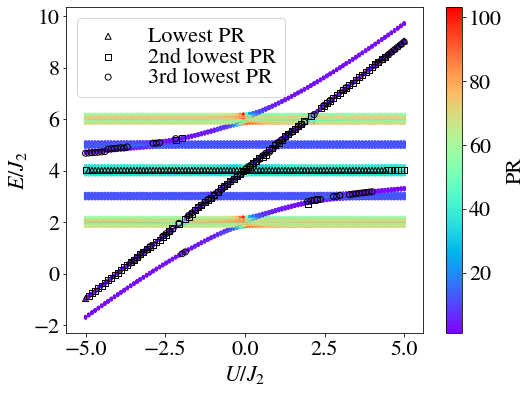

In [321]:
plt.figure(figsize=[8,6]) #Size of the plot
#For each state we plot the evolution of E(U), the color represents the PR
for j in range(n_eigval):
    #plt.plot(U_array/J2, EvsU[:, j]/J_m, color='black', zorder=0, linewidth=1)
    cmap1=mpl.cm.get_cmap('rainbow')
    plt.scatter(U_array/J2, EvsU[:, j]/JM, c=PRvsU[:, j], cmap=cmap1, s=5)
    plt.clim(minPR, maxPR)
    
#Plot the energy bands of the Dimer
"""plt.plot(U_array/J2, 2*ω+0.5*U_array/J2+np.sqrt(0.25*U_array**2+4*J2**2)/J2, label='Dimer Energy Bands', color='black')#plt.plot(U_array/J2, 0.5*U_array/J2-np.sqrt(0.25*U_array**2+4*J2**2)/J2, color='black')
plt.plot(U_array/J2, 2*ω+U_array/J2, color='black')
plt.plot(U_array/J2, 2*ω+0.5*U_array/J2-np.sqrt(0.25*U_array**2+4*J2**2)/J2, color='black')"""

#plt.hlines(0, U_min, U_max, alpha=0.5)
#plt.vlines(0, -10, 10, alpha=0.5)
#plt.vlines(5, -10, 10, color='red')
#plt.hlines(4, -8, 8, color='blue', linestyle='dashed', label='Scattering band')
#plt.hlines(-4, -8, 8, color='blue', linestyle='dashed')
#plt.xlim(0,6)
#plt.ylim(1.5, 11)
cb=plt.colorbar()
cb.set_label(label='PR')
#This part of the code puts a geometric shape on top of the three lowest PR's
plt.scatter(U_array[0]/J2, EvsU[ 0, min1PR[0]]/JM, facecolors='none', color='black', marker="^", label='Lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min2PR[0]]/JM, facecolors='none', color='black', marker="s", label='2nd lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min3PR[0]]/JM, facecolors='none', color='black', marker="o", label='3rd lowest PR')
for j in range(1, n_points):
    plt.scatter(U_array[j]/J2, EvsU[ j, min1PR[j]]/JM, facecolors='none', color='black', marker="^")
    plt.scatter(U_array[j]/J2, EvsU[ j, min2PR[j]]/JM, facecolors='none', color='black', marker="s")
    plt.scatter(U_array[j]/J2, EvsU[ j, min3PR[j]]/JM, facecolors='none', color='black', marker="o")
#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap='gist_rainbow')
#plt.title("Energy versus U SSH of N="+str(N)+" ω="+ str(ω)+ " J1="+str(J1)+ " J2="+str(J2))
plt.ylabel("$E/J_2$")
plt.xlabel("$U/J_2$")
plt.legend(labelspacing=0)
#plt.savefig('EvsU_SSH_'+str(N)+'_'+ str(ω)+ '_'+str(J1)+ '_'+str(J2)+'.png')
plt.show()